In [8]:
%pylab inline
import scipy.signal
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import cde
import autograd.numpy as anp
import tqdm, corner


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [9]:


def jansen_rit_sigmoid(x, v_max, v_0, r):
    """Sigmoid function for the Jansen-Rit model."""
    return v_max / (1.0 + anp.exp(r * (v_0 - x)))

def jansen_rit_ode(y, t, A, B, a, b, v0, C1, C2, C3, C4, p_mu, p_sigma):
    """
    Defines the system of differential equations for the Jansen-Rit model.
    This function is compatible with scipy.odeint.
    """
    y0, y1, y2, y3, y4, y5 = y
    v_max = 5.0
    r = 0.56

    sig_y1 = jansen_rit_sigmoid(y1 - y2, v_max, v0, r)
    sig_y0_c1 = jansen_rit_sigmoid(C1 * y0, v_max, v0, r)
    sig_y0_c3 = jansen_rit_sigmoid(C3 * y0, v_max, v0, r)

    dy0 = y3
    dy1 = y4
    dy2 = y5
    dy3 = A * a * sig_y1 - 2 * a * y3 - a**2 * y0
    dy4 = A * a * (p_mu + C2 * sig_y0_c1) - 2 * a * y4 - a**2 * y1
    dy5 = B * b * (C4 * sig_y0_c3) - 2 * b * y5 - b**2 * y2

    return [dy0, dy1, dy2, dy3, dy4, dy5]

def extract_features(simulations: anp.ndarray, fs: float, nperseg: int = 256):
    """
    Extracts features (mean, var, PSD) from a batch of simulations.

    Parameters
    ----------
    simulations : anp.ndarray
        Array of time series, shape (n_simulations, n_timesteps).
    fs : float
        Sampling frequency.
    nperseg : int
        Segment length for Welch's method.

    Returns
    -------
    anp.ndarray
        Feature array of shape (n_simulations, n_features).
    """
    # Mean and variance
    mean_feat = anp.mean(simulations, axis=1, keepdims=True)
    var_feat = anp.var(simulations, axis=1, keepdims=True)

    # Power Spectral Density (PSD) using Welch's method
    freqs, psd = scipy.signal.welch(simulations, fs=fs, nperseg=nperseg)

    # Use log-power of frequencies up to 100 Hz
    freq_idx = freqs <= 100
    log_psd = anp.log10(psd[:, freq_idx] + 1e-10)

    return anp.hstack([mean_feat, var_feat, log_psd])

def generate_jr_data(n_sims: int, seed: int = 0):
    """
    Generates a dataset of Jansen-Rit parameters and corresponding features using scipy.odeint.
    NOTE: This version is significantly slower due to serial simulation.
    """
    rng = anp.random.RandomState(seed)

    param_labels = ['A', 'B', 'a', 'b']
    default_params = {'A': 3.25, 'B': 22.0, 'a': 100.0, 'b': 50.0, 'v0': 6.0, 'C': 135.0}
    priors = {
        'A': (default_params['A'], 0.2),
        'B': (default_params['B'], 1.5),
        'a': (default_params['a'], 5.0),
        'b': (default_params['b'], 2.5),
    }

    n_varied_params = len(param_labels)
    sampled_params = anp.array([rng.randn(n_sims) * std + mean for mean, std in priors.values()]).T

    # Simulation settings
    fs = 1000.0
    duration = 1.0
    t_span = anp.linspace(0, duration, int(duration * fs))
    y0 = anp.zeros(6) # Initial conditions
    p_mu, p_sigma = 220.0, 50.0 # Noise parameters (odeint doesn't handle SDEs, so we omit noise)

    sim_outputs = anp.zeros((n_sims, len(t_span)))

    # --- Serial simulation loop ---
    iterator = tqdm.trange(n_sims, desc="Simulating JR model (serial)")
    for i in iterator:
        A, B, a, b = sampled_params[i]
        v0 = default_params['v0']
        C = default_params['C']
        C1, C2, C3, C4 = C, C, 0.8 * C, 0.25 * C

        args = (A, B, a, b, v0, C1, C2, C3, C4, p_mu, p_sigma)
        sol = odeint(jansen_rit_ode, y0, t_span, args=args)
        sim_outputs[i, :] = sol[:, 1] - sol[:, 2] # Pyramidal potential

    features = extract_features(sim_outputs, fs)

    return sampled_params, features, param_labels

def run_jr_test(estimator: cde.ConditionalDensityEstimator, n_train: int = 2000, n_samples_posterior: int = 500):
    """
    Runs the high-dimensional Jansen-Rit model test.
    """
    print(f"\n--- Running Jansen-Rit test for {estimator.__class__.__name__} ---")

    # 1. Generate training data
    params_train, features_train, param_labels = generate_jr_data(n_train)

    # 2. Train the estimator
    estimator.train(params_train, features_train, n_iter=500, learning_rate=1e-3, use_tqdm=True)

    # 3. Generate a single "true" observation to recover
    true_params, true_features, _ = generate_jr_data(1, seed=42)

    # 4. Sample from the learned posterior p(params | true_features)
    rng = anp.random.RandomState(123)
    posterior_samples = estimator.sample(true_features, n_samples_posterior, rng)[0]

    # 5. Visualize the posterior
    print("Plotting posterior marginals...")
    fig = corner.corner(
        posterior_samples,
        labels=param_labels,
        truths=true_params[0],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 12},
        truth_color='red'
    )
    fig.suptitle(f"Posterior Recovery for {estimator.__class__.__name__}", fontsize=16)
    plt.show()



Simulating JR model (serial): 100%|██████████| 1/1 [00:00<00:00, 43.16it/s]

Jansen-Rit Test: Parameter Dim=4, Feature Dim=28

--- Running Jansen-Rit test for MDNEstimator ---


Simulating JR model (serial): 100%|██████████| 2000/2000 [00:25<00:00, 78.71it/s]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Simulating JR model (serial): 100%|██████████| 1/1 [00:00<00:00, 14.86it/s]


Plotting posterior marginals...


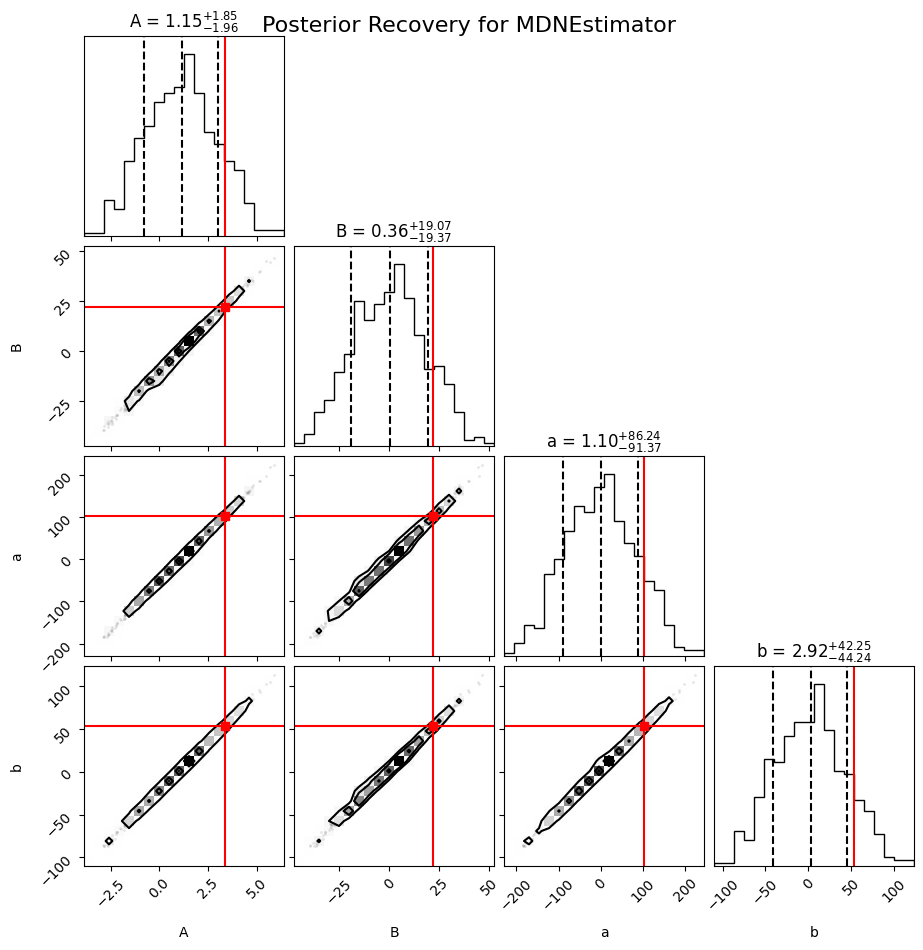


--- Running Jansen-Rit test for MAFEstimator ---


Simulating JR model (serial): 100%|██████████| 2000/2000 [00:28<00:00, 69.13it/s]


Training:   0%|          | 0/500 [00:00<?, ?it/s]

Simulating JR model (serial): 100%|██████████| 1/1 [00:00<00:00, 12.77it/s]


Plotting posterior marginals...


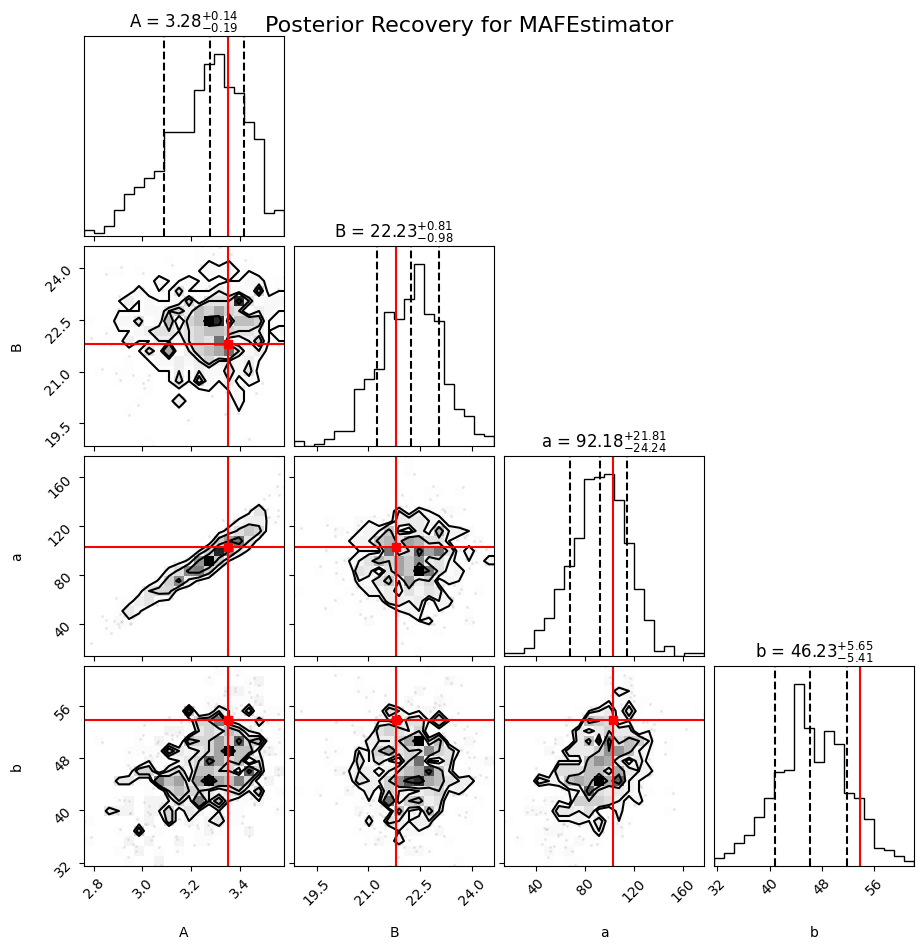

In [10]:

# --- Jansen-Rit High-Dimensional Tests ---
# Define parameter and feature dimensions based on the generator function
# 4 varied parameters, and features are mean, var, + PSD bins
# Run once to get dimensions
_, features_sample, _ = generate_jr_data(1)
param_dim_jr = 4
feature_dim_jr = features_sample.shape[1]
print(f"Jansen-Rit Test: Parameter Dim={param_dim_jr}, Feature Dim={feature_dim_jr}")

# MDN Test
mdn_jr = cde.MDNEstimator(
    param_dim=param_dim_jr, 
    feature_dim=feature_dim_jr, 
    n_components=10, 
    hidden_sizes=(128, 128)
)
run_jr_test(mdn_jr)

# MAF Test
maf_jr = cde.MAFEstimator(
    param_dim=param_dim_jr, 
    feature_dim=feature_dim_jr, 
    n_flows=5, 
    hidden_units=128
)
run_jr_test(maf_jr)
